In [417]:
# !pip install PyPDF2
# !pip install nltk
# !pip install pdfminer
# !pip install scikit-learn
# !pip install lda

     |████████████████████████████████| 9.0 MB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 15.6 MB/s eta 0:00:01
     |████████████████████████████████| 35.0 MB 11.9 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [ ]:
from PyPDF2 import PdfReader
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from os import listdir

In [644]:
case = []
case_numbers = []
order = []
all_content = {'doc': [], 'vcat_no': [], 'case_no': [],
               'applicant': [], 'respondent': [], 'owner': [], 'builder': [],
               'catchwords': [], 'order': []
              }
i = 1
for i,doc in enumerate(listdir('sample_pdf/')):
# for doc in ['_au_cases_vic_VCAT_2016_1790.pdf']:
#     print(doc)
    reader = PdfReader(f"sample_pdf/{doc}")
    text = reader.pages[0].extract_text()+reader.pages[1].extract_text()+reader.pages[2].extract_text()
    case_no = ''
    case_num = i
    section = {'doc': True, 'is_vcat_no': False, 'case_no':True, 
               'is_applicant': False, 'is_respondent': False, 'is_owner': False, 'is_builder': False,
               'is_catchwords': False, 'is_order': False
              }
    case = {'doc': [], 'vcat_no': [], 'case_no': [], 
            'applicant': [], 'respondent': [], 'owner': [], 'builder': [],
            'catchwords': [], 'order': []
           }
    
    order_found = False
    respondent_found = False
    for line_no, line in enumerate(text.split('\n')):
#         print(line)
        line = line.strip()
        if len(line) == 0:
            continue
        new_section_detected = False
        if line.split(' ')[0].isupper() and not bool(re.search(r'[-\[\]\;]', line)):
            new_section_detected = True
            if new_section_detected and section['is_order']:
                order_found = True
            if new_section_detected and section['is_respondent']:
                respondent_found = True
#         print(new_section_detected)
        try:
            if not section['is_vcat_no']:
                if bool(re.search(r'([A-Z]{2}\s*\d+\/\d+)', line)) or bool(re.search(r'([A-Z]\s*\d+\/\d+)', line)):
                    section['is_vcat_no'] = True
                    if bool(re.search(r'[A-Z]{2}\s*\d+\/\d+', line)):
                        case['vcat_no'].append(re.search(r'([A-Z]{2}\s*\d+\/\d+)', line).group(0))
                    else:
                        case['vcat_no'].append(re.search(r'([A-Z]\s*\d+\/\d+)', line).group(0))
            elif not section['is_catchwords'] or \
            (not new_section_detected and section['is_catchwords'] and not section['is_applicant']) or \
            (new_section_detected and section['is_catchwords'] and case['catchwords'] == []):
                if bool(re.search(r'CATCHWORDS', line)):
                    section['is_catchwords'] = True
                else: 
                    case['catchwords'].append(line)

            elif not section['is_applicant'] or \
            (not new_section_detected and section['is_applicant'] and not section['is_respondent']) or \
            (new_section_detected and bool(re.search(r'APPLICANT', line)) and not section['is_respondent']):
                if bool(re.search(r'APPLICANT', line)):
                    section['is_applicant'] = True
                if not bool(re.search(r'APPLICANT', line)):
                    case['applicant'].append(line)
                else:
                    case['applicant'].append(re.search(r'APPLICANT[\:|S|\s](.*)', line).group(0))

            elif not section['is_respondent'] or \
            (not new_section_detected and section['is_respondent'] and not respondent_found) or \
            (new_section_detected and bool(re.search(r'RESPONDENT', line))):
                if bool(re.search(r'RESPONDENT', line)):
                    section['is_respondent'] = True
                if not bool(re.search(r'RESPONDENT', line)):
                    case['respondent'].append(line)
                else:
                    case['respondent'].append(re.search(r'RESPONDENT[S|\s](.*)', line).group(0))
            elif not section['is_order'] or \
            (not new_section_detected and section['is_order'] and not order_found):
                if bool(re.search(r'ORDER', line)) and not bool(re.search(r'DATE OF ORDER', line)):
                        section['is_order'] = True
                if len(line.split(' ')) > 1:
                    if bool(re.search('MEMBER|JUDGE|PRESIDENT', line.upper())) or bool(re.search('PAGE \d OF \d', line.upper())):
                        continue
                    if not new_section_detected and section['is_order']:
                        case['order'].append(line)
                else:
                    continue
            elif not section['is_owner']:
                if bool(re.search(r'\(.*OWNER.*\)', line.upper())):
#                     print(re.search(r'(.*\s.*)\s\(.*OWNER.*\)', line.upper()).group(0))
                    section['is_owner'] = True
                    case['owner'].append(re.search(r'(.{0,20})\s\(.*OWNER.*\)', line.upper()).group(0))
            elif not section['is_builder']:
                if bool(re.search(r'\(.*BUILDER.*\)', line.upper())):
                    section['is_builder'] = True
                    case['builder'].append(re.search(r'(.{0,20})\s\(.*BUILDER.*\)', line.upper()).group(0))
        except:
            continue
        if all(list(section.values())) or line_no + 1 == len(text.split('\n')):
            all_content['doc'].append(doc)
            all_content['vcat_no'].append(' '.join(case['vcat_no']))
            all_content['case_no'].append(case_num)
            all_content['applicant'].append(' '.join(case['applicant']))
            all_content['respondent'].append(' '.join(case['respondent']))
            all_content['owner'].append(' '.join(case['owner']))
            all_content['builder'].append(' '.join(case['builder']))
            all_content['catchwords'].append(' '.join(case['catchwords']))
            all_content['order'].append(' '.join(case['order']))
            break
#     for key, value in all_content.items():
#         print(f"{key} {value}")

In [658]:
all_content_df = pd.DataFrame(all_content)

In [660]:
def find_builder(field, prmy_a_field, prmy_r_field):
    if 'APPLICANT' in field.upper():
        return 'APPLICANT'
    elif 'RESPONDENT' in field.upper():
        return 'RESPONDENT'
    elif 'PTY' in prmy_a_field.upper() or 'LTD' in prmy_a_field.upper():
        return 'APPLICANT'
    elif 'PTY' in prmy_r_field.upper() or 'LTD' in prmy_r_field.upper():
        return 'RESPONDENT'
    else:
        return ''

def find_owner(o_field, b_field, prmy_a_field, prmy_r_field):
    if 'APPLICANT' in o_field.upper():
        return 'APPLICANT'
    elif 'RESPONDENT' in o_field.upper():
        return 'RESPONDENT'
    elif b_field != '' and b_field == 'APPLICANT':
        return 'RESPONDENT'
    elif b_field != '' and b_field == 'RESPONDENT':
        return 'APPLICANT'
    elif o_field != '' and set(o_field.upper().split(' ')) & set(prmy_r_field.upper().split(' ')):
        return 'RESPONDENT'
    elif o_field != '' and set(o_field.upper().split(' ')) & set(prmy_a_field.upper().split(' ')):
        return 'APPLICANT'
    else:
        return ''
all_content_df['builder'] = [find_builder(i[0],i[1],i[2]) for i in zip(all_content_df['builder'], 
                                                                        all_content_df['applicant'], 
                                                                        all_content_df['respondent'])]
all_content_df['owner'] = [find_owner(i[0],i[1],i[2],i[3]) for i in zip(all_content_df['owner'], 
                                                                        all_content_df['builder'],
                                                                        all_content_df['applicant'], 
                                                                        all_content_df['respondent'])]


In [661]:
all_content_df

,doc,vcat_no,case_no,applicant,respondent,owner,builder,catchwords,order
0,_au_cases_vic_VCAT_2019_397.pdf,BP 1469/2018,0,APPLICANT Hayley Brivik APPLICANT Hadley Bortz,RESPONDENT Bernard Opat Pty Ltd,APPLICANT,RESPONDENT,Domestic Building Contracts Act 1995 ; implied...,"1 The respondent must pay the applicants $6,77..."
1,_au_cases_vic_VCAT_2016_1790.pdf,BP282/2015,1,APPLICANT True Blue Homes Pty Ltd (ACN 118 73...,RESPONDENT Mr John Kaye RESPONDENT Ms Yvonne...,RESPONDENT,APPLICANT,DOMESTIC BUILDING DISPUTE – Variations – whet...,1. The Applicant must pay the Respondent s $45...
2,_au_cases_vic_VCAT_2018_386.pdf,BP 1110/2015,2,APPLICANT Ya Ge Xu APPLICANT Qing Xiao Chen,RESPONDENT Hallbuild Pty Ltd (ACN 155 388 604),APPLICANT,RESPONDENT,Application for reinstatement of proceeding; e...,1. The proceeding is reinstated. 2. The respon...
3,_au_cases_vic_VCAT_2014_1502.pdf,D 1333/2012,3,APPLICANT Mr Earl Softley APPLICANT Ms Shell...,RESPONDENT Metricon Homes Pty Ltd (ACN 005 10...,APPLICANT,RESPONDENT,Building and Property List; major domestic bui...,1 Within seven days the parties must bring in ...
4,_au_cases_vic_VCAT_2022_29.pdf,BP389/2019,4,APPLICANT Tania De Vincentis,RESPONDENT SDJ Property Fifth Pty Ltd (ACN 11...,APPLICANT,RESPONDENT,Victorian Civil and Administrative Tribunal Ac...,1. The claims relating to the bathrooms and po...
...,...,...,...,...,...,...,...,...,...
484,_au_cases_vic_VCAT_2021_898.pdf,BP2209/2019,498,PROCEEDING BP2209/2019 APPLICANT Ali Kemar El...,RESPONDENTS Patrick Veszpremi and Melissa Ve...,RESPONDENT,,Proceeding BP2209/2019. Domestic Building Wor...,
485,_au_cases_vic_VCAT_2012_840.pdf,D93/2011,499,"OWNERS Clint on Wayne Anderson, Brandi Lee Do...",,,,Costs – Victorian Civil and Administrative Tri...,
486,_au_cases_vic_VCAT_2014_1282.pdf,D1266/2012,500,APPLICANT OWNERS CORPORATION NO 1,PS611203E RESPONDENT FURMAN CONSTRUCTIONS PTY...,APPLICANT,RESPONDENT,19 unit residential town -house development -v...,"1. For the reasons provided, the respondent m..."
487,_au_cases_vic_VCAT_2010_1263.pdf,D356/2009,501,RESPONDENT Robert Gordon Adam WHERE HELD Mel...,,,,APPLICANT Rena Mary Eid CITATION Eid v Adam ...,


In [663]:
all_content_df.to_csv('rbe_case_info_extraction.csv', index=False)

In [400]:
all_content_df2.duplicated('doc')

,doc,vcat_no,case_no,applicant,respondent,owner,builder,catchwords,order


In [662]:
for col in all_content_df.columns:
    print(f"{col} {1-sum([1 for i in all_content_df[col] if i == ''])/len(all_content_df):.0%}")

doc 100%
vcat_no 99%
case_no 100%
applicant 90%
respondent 84%
owner 72%
builder 67%
catchwords 99%
order 84%


### Basic Analysis

In [470]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import numpy as np
%matplotlib inline

In [510]:
cw_no_symb = [re.sub(r'\W+\s+', ' ', chunk) for chunk in all_content_df2.catchwords]

In [511]:
cw_no_num = [re.sub(r'\d+', ' ', chunk) for chunk in cw_no_symb]

In [519]:
cw_no_brack = [re.sub(r'[\(\)\[\]\-\$\:]', ' ', chunk) for chunk in cw_no_num]

In [520]:
cw_no_brack

['Domestic Building Contracts Act   implied warranties whether the building works are defective whether respondent builder liable for water damage assessment of damages whether the applicants entitled to costs .',
 'DOMESTIC BUILDING DISPUTE Variations whether s     of the Domestic Building Contracts Act   operates where the parties have agreed that additional foundation work is a variation to the scope of the work under the contract Betterment whether a credit should be given where damages put a party in a better position than had the breach not occurred Rectification orders whether it is appropriate to order that a builder undertake repairs in lieu of paying damages Delay whether a written extension of time notice is mandatory and a precondition to any entitlement to e xtend time under the contract whether a clause which provides for liquidated damages in respect of delay constitutes a dispositive remedial code and caps any entitlement to damages at common law .',
 'Application for r

In [597]:
vect=TfidfVectorizer(stop_words=stop_words,max_features=2000)
vect_text=vect.fit_transform(cw_no_brack)

In [598]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=1) 
lda_top=lda_model.fit_transform(vect_text)

In [599]:
topic_distribution = pd.DataFrame(lda_top)

(array([0.0204499 , 0.02953874, 0.05226085, 0.02726653, 0.00454442,
        0.00454442, 0.00227221, 0.84753465, 0.06589411, 0.05680527]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

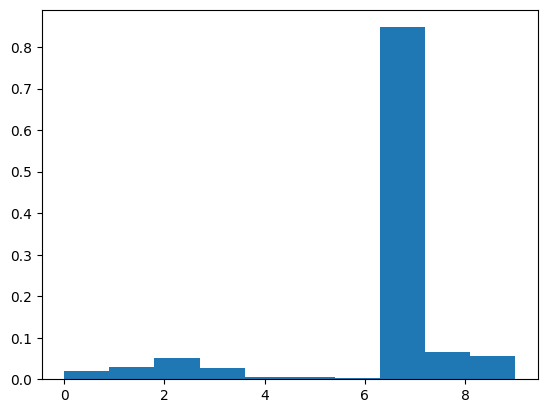

In [603]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(list(topic_distribution.idxmax(axis=1)), density=True, bins=10) 

In [601]:
print("Document 0: ")
for i,topic in enumerate(lda_top[488]):
    print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  1.8651390696857388 %
Topic  1 :  1.8651767811250144 %
Topic  2 :  1.8652216382730205 %
Topic  3 :  1.8651791903759454 %
Topic  4 :  1.8651735567925716 %
Topic  5 :  1.8651319569439853 %
Topic  6 :  1.865139176182717 %
Topic  7 :  83.21342950708993 %
Topic  8 :  1.8651647441408787 %
Topic  9 :  1.865244379390208 %


In [596]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words = stop_words + ['if','is','so','vo','mr','wa','mw',
                           'per','use','was','all','also','made','cant',
                           'therefore','include', 'issues','causes','subject','respondent','applicant',
                           'managed','particularly','alternatively','previously','number','matter','around'
                          ]

In [602]:
vocab = vect.vocabulary_
for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print('\n')

Topic 0: 
aware cecco mouldings performed completing unsworn serving poor single unit 

Topic 1: 
performed conferred interest leasing low fixing ts pre mouldings reach 

Topic 2: 
advising leaks mouldings arrange record meaning performed leasing unsworn interest 

Topic 3: 
distress undertake rta allowable determination arrange inspection conferred contract fixing 

Topic 4: 
leasing arrange swimming best frustrated private serving unit single performed 

Topic 5: 
relevantly two poor performed reach sic cecco interest buch initial 

Topic 6: 
contract performed eid indemnity poor due compliance mouldings quality documents 

Topic 7: 
performed interest poor leasing mouldings cecco contract rooms unsworn deduct 

Topic 8: 
determination rta undertake allowable distress contract arrange division performed must 

Topic 9: 
performed cecco offer poor sub interest mouldings eid contract unsworn 



### Problematic PDFs

In [611]:
# _au_cases_vic_VCAT_2022_29.pdf
# _au_cases_vic_VCAT_2020_1104.pdf
# _au_cases_vic_VCAT_2004_1561.pdf
# _au_cases_vic_VCAT_2022_1156.pdf
checks = ['_au_cases_vic_VCAT_2016_2065.pdf',
'_au_cases_vic_VCAT_2017_1544.pdf',
'_au_cases_vic_VCAT_2012_1570.pdf',
'_au_cases_vic_VCAT_2012_1570.pdf',
'_au_cases_vic_VCAT_2013_1148.pdf',
'_au_cases_vic_VCAT_2012_1404.pdf',
'_au_cases_vic_VCAT_2017_329.pdf',
'_au_cases_vic_VCAT_2012_1968.pdf',
'_au_cases_vic_VCAT_2022_1019.pdf',
'_au_cases_vic_VCAT_2004_1361.pdf',
'_au_cases_vic_VCAT_2015_1510.pdf',
'_au_cases_vic_VCAT_2005_2443.pdf',
'_au_cases_vic_VCAT_2019_435.pdf',
'_au_cases_vic_VCAT_2008_2631.pdf',
'_au_cases_vic_VCAT_2015_1473.pdf',
'_au_cases_vic_VCAT_2018_963.pdf',
'_au_cases_vic_VCAT_2020_1129.pdf',
'_au_cases_vic_VCAT_2017_307.pdf',
'_au_cases_vic_VCAT_2019_1206.pdf',
'_au_cases_vic_VCAT_2015_1472.pdf',
'_au_cases_vic_VCAT_2020_1458.pdf',
'_au_cases_vic_VCAT_2017_1596.pdf',
'_au_cases_vic_VCAT_2012_1205.pdf',
'_au_cases_vic_VCAT_2021_1074.pdf',
'_au_cases_vic_VCAT_2005_821.pdf',
'_au_cases_vic_VCAT_2016_211.pdf',
'_au_cases_vic_VCAT_2022_699.pdf',
'_au_cases_vic_VCAT_2004_2341.pdf',
'_au_cases_vic_VCAT_2018_641.pdf',
'_au_cases_vic_VCAT_2013_1275.pdf',
'_au_cases_vic_VCAT_2015_1748.pdf',
'_au_cases_vic_VCAT_2016_2004.pdf',
'_au_cases_vic_VCAT_2016_399.pdf',
'_au_cases_vic_VCAT_2014_277.pdf',
'_au_cases_vic_VCAT_2004_2035.pdf',
'_au_cases_vic_VCAT_2015_2042.pdf',
'_au_cases_vic_VCAT_2015_105.pdf',
'_au_cases_vic_VCAT_2017_992.pdf',
'_au_cases_vic_VCAT_2009_912.pdf',
'_au_cases_vic_VCAT_2006_1972.pdf',
'_au_cases_vic_VCAT_2005_2031.pdf',
'_au_cases_vic_VCAT_2019_1716.pdf',
'_au_cases_vic_VCAT_2011_1626.pdf',
'_au_cases_vic_VCAT_2018_679.pdf',
'_au_cases_vic_VCAT_2018_679.pdf',
'_au_cases_vic_VCAT_2012_432.pdf',
'_au_cases_vic_VCAT_2022_1086.pdf',
'_au_cases_vic_VCAT_2020_799.pdf',
'_au_cases_vic_VCAT_2020_799.pdf',
'_au_cases_vic_VCAT_2022_1247.pdf',
'_au_cases_vic_VCAT_2019_1270.pdf',
'_au_cases_vic_VCAT_2006_1972 (2).pdf',
'_au_cases_vic_VCAT_2009_2337.pdf',
'_au_cases_vic_VCAT_2009_2337.pdf',
'_au_cases_vic_VCAT_1998_2.pdf',
'_au_cases_vic_VCAT_1998_2.pdf',
'_au_cases_vic_VCAT_2002_382.pdf',
'_au_cases_vic_VCAT_2002_382.pdf',
'_au_cases_vic_VCAT_2018_1305.pdf',
'_au_cases_vic_VCAT_2017_209.pdf',
'_au_cases_vic_VCAT_2018_1485.pdf',
'_au_cases_vic_VCAT_2019_1877.pdf',
'_au_cases_vic_VCAT_2020_1422.pdf',
'_au_cases_vic_VCAT_2006_1216.pdf',
'_au_cases_vic_VCAT_2020_839.pdf',
'_au_cases_vic_VCAT_2006_1972 (1).pdf',
'_au_cases_vic_VCAT_2012_1097.pdf',
'_au_cases_vic_VCAT_2009_2649.pdf',
'_au_cases_vic_VCAT_2009_2649.pdf',
'_au_cases_vic_VCAT_2011_1165.pdf',
'_au_cases_vic_VCAT_2022_724.pdf',
'_au_cases_vic_VCAT_2012_213.pdf',
'_au_cases_vic_VCAT_2012_213.pdf',
'_au_cases_vic_VCAT_2018_1531.pdf',
'_au_cases_vic_VCAT_2019_1294.pdf',
'_au_cases_vic_VCAT_2004_1520.pdf',
'_au_cases_vic_VCAT_2004_1521.pdf',
'_au_cases_vic_VCAT_2018_1242.pdf',
'_au_cases_vic_VCAT_2016_391.pdf',
'_au_cases_vic_VCAT_2004_1086.pdf',
'_au_cases_vic_VCAT_2019_1732.pdf',
'_au_cases_vic_VCAT_2012_35.pdf',
'_au_cases_vic_VCAT_2022_494.pdf',
'_au_cases_vic_VCAT_2014_1036.pdf',
'_au_cases_vic_VCAT_2021_1222.pdf',
'_au_cases_vic_VCAT_2014_858.pdf',
'_au_cases_vic_VCAT_2014_858.pdf',
'_au_cases_vic_VCAT_2017_1461.pdf',
'_au_cases_vic_VCAT_2017_1893.pdf',
'_au_cases_vic_VCAT_2017_1893.pdf',
'_au_cases_vic_VCAT_2005_915.pdf',
'_au_cases_vic_VCAT_2013_58.pdf',
'_au_cases_vic_VCAT_2017_1892.pdf',
'_au_cases_vic_VCAT_2017_1892.pdf',
'_au_cases_vic_VCAT_2017_14.pdf',
'_au_cases_vic_VCAT_2012_798.pdf',
'_au_cases_vic_VCAT_2021_1223.pdf',
'_au_cases_vic_VCAT_2010_1201.pdf',
'_au_cases_vic_VCAT_2021_1221.pdf',
'_au_cases_vic_VCAT_2015_2058.pdf',
'_au_cases_vic_VCAT_2021_150.pdf',
'_au_cases_vic_VCAT_2001_1921.pdf',
'_au_cases_vic_VCAT_2021_347.pdf',
'_au_cases_vic_VCAT_2019_299.pdf',
'_au_cases_vic_VCAT_2018_1046.pdf',
'_au_cases_vic_VCAT_2021_1220.pdf',
'_au_cases_vic_VCAT_2010_1599.pdf',
'_au_cases_vic_VCAT_2014_1292.pdf',
'_au_cases_vic_VCAT_2014_975.pdf',
'_au_cases_vic_VCAT_2019_1009.pdf',
'_au_cases_vic_VCAT_2019_1960.pdf',
'_au_cases_vic_VCAT_2020_480.pdf',
'_au_cases_vic_VCAT_2019_228.pdf',
'_au_cases_vic_VCAT_2005_2909.pdf',
'_au_cases_vic_VCAT_2020_1130.pdf',
'_au_cases_vic_VCAT_2006_440.pdf',
'_au_cases_vic_VCAT_2014_380.pdf',
'_au_cases_vic_VCAT_2012_1237.pdf',
'_au_cases_vic_VCAT_2022_182.pdf',
'_au_cases_vic_VCAT_2022_182.pdf',
'_au_cases_vic_VCAT_2008_575.pdf',
'_au_cases_vic_VCAT_2022_1216.pdf',
'_au_cases_vic_VCAT_2012_1949.pdf',
'_au_cases_vic_VCAT_2022_178.pdf',
'_au_cases_vic_VCAT_2019_1741.pdf',
'_au_cases_vic_VCAT_2014_1083.pdf',
'_au_cases_vic_VCAT_2018_188.pdf',
'_au_cases_vic_VCAT_2019_1352.pdf',
'_au_cases_vic_VCAT_2016_1005.pdf',
'_au_cases_vic_VCAT_2017_1944.pdf',
'_au_cases_vic_VCAT_2021_286.pdf',
'_au_cases_vic_VCAT_2014_1532.pdf',
'_au_cases_vic_VCAT_2018_1756.pdf',
'_au_cases_vic_VCAT_2015_578.pdf',
'_au_cases_vic_VCAT_2009_1899.pdf',
'_au_cases_vic_VCAT_2017_483.pdf',
'_au_cases_vic_VCAT_2012_277.pdf',
'_au_cases_vic_VCAT_2021_49.pdf']
